<a href="https://colab.research.google.com/github/SRINIRAGZ/sentimentAnalysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clone the git repo

In [1]:
from getpass import getpass

# Securely ask for GitHub token
token = getpass("Enter your GitHub token: ")
!git clone https://{token}@github.com/SRINIRAGZ/sentimentAnalysis.git

Enter your GitHub token: ··········
Cloning into 'sentimentAnalysis'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 564.09 KiB | 1.49 MiB/s, done.
Resolving deltas: 100% (6/6), done.


### Installation of libraries

In [2]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [48]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: /content


### Configs

In [9]:
##PArams
filename = 'engagements.csv'
DataFolder = './sentimentAnalysis/data/{filename}'
ResultsFolder = './sentimentAnalysis/results/{filename}'

### Data Import

In [11]:
df = pd.read_csv(DataFolder.format(filename=filename))

In [27]:
df.head()

,timestamp,media_id,media_caption,comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️


## Data Cleaning

In [34]:
df['media_caption'] = df['media_caption'].astype(str)
df['comment_text'] = df['comment_text'].astype(str)

In [29]:
maxlen = df[['media_caption','comment_text']].apply(lambda x: x.str.len().max())
print(maxlen)


media_caption    993.0
comment_text     745.0
dtype: float64


In [40]:
#Clean Mentions in comment
df['comment_text'] = df['comment_text'].str.replace(r'@\w+', '', regex=True)

In [63]:
df.columns

Index(['timestamp', 'media_id', 'media_caption', 'comment_text', 'sentiment',
       'sentiment_score', 'cluster'],
      dtype='object')

In [67]:
#cleaning duplicates
df.drop_duplicates(inplace=True)
df.sort_values('timestamp', inplace=True)
df['aggcol'] = df[['media_id', 'media_caption', 'comment_text']].apply(tuple, axis=1)
df.drop_duplicates(subset='aggcol', keep='first', inplace=True)
df.drop(columns=['aggcol'], inplace=True)
df.shape

(9188, 7)

## Data PreProcessing

## Sentiment Analysis

Using RoBERTa model to analyse sentiment because its a robust pretrained BERT model optimized for sentiment analysis. BERT also is better at understanding context

In [41]:
#model params
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
label_mapping = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}

In [36]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load sentiment analysis pipeline

sentiment_classifier = pipeline("sentiment-analysis", model=MODEL)


Device set to use cuda:0


In [ ]:
# Run sentiment analysis

results = sentiment_classifier(list(df['comment_text']))

In [45]:
# Display results
i=0
for comment, result in zip(df['comment_text'], results):
    print(f"{comment} => {label_mapping[result['label']]} (score: {result['score']:.2f})")
    print(result)
    if i>5:
      break
    i+=1

I bet this is good => Positive (score: 0.97)
{'label': 'LABEL_2', 'score': 0.9709283113479614}
i know this smells so good => Positive (score: 0.98)
{'label': 'LABEL_2', 'score': 0.9758529663085938}
Love it => Positive (score: 0.92)
{'label': 'LABEL_2', 'score': 0.9205260276794434}
Please carry these in Canada! I miss them so much! => Positive (score: 0.56)
{'label': 'LABEL_2', 'score': 0.5638464689254761}
I love it ..✌️ => Positive (score: 0.98)
{'label': 'LABEL_2', 'score': 0.9764512777328491}
Anndy Marin => Neutral (score: 0.70)
{'label': 'LABEL_1', 'score': 0.7040501236915588}
Shaheena Juliet Castellano Flavors?🧐
I know you not …nevermind, I’ll just keep scrolling 👩🏽‍🦯‍➡️ => Neutral (score: 0.66)
{'label': 'LABEL_1', 'score': 0.6600942015647888}


In [46]:
#Rework on the dataframe with sentiment results
df['sentiment'] = [label_mapping[result['label']] for result in results]
df['sentiment_score'] = [result['score'] for result in results]
df.head()

,timestamp,media_id,media_caption,comment_text,sentiment,sentiment_score
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,0.970928
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,0.975853
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,0.920526
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,0.563846
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,0.976451


In [47]:
df['sentiment'].value_counts()

,count
sentiment,
Neutral,11654
Positive,5627
Negative,560


### Looking for Semantic Similarities between media text

Semantic similarities can be achieved using mini language models which help in identifying clusters in language models and also help in clustering. Here our aim is to cluster using the embeddings we can further chalk analyze based on individula clusters.

In [62]:
#params
MODEL='all-mpnet-base-v2' #'all-MiniLM-L12-v2'

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Generate embeddings
embedder = SentenceTransformer(MODEL)
embeddings = embedder.encode(list(df['media_caption']))



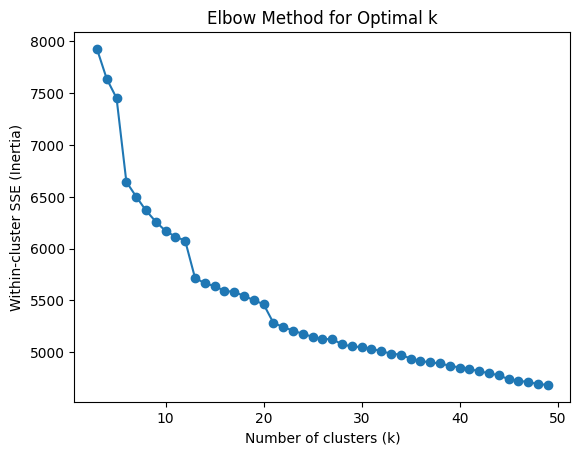

[7928.3046875, 7639.01611328125, 7453.7255859375, 6645.1572265625, 6502.7666015625, 6368.54931640625, 6261.265625, 6170.8818359375, 6116.28564453125, 6076.88330078125, 5719.42724609375, 5665.45263671875, 5639.0283203125, 5593.099609375, 5582.06787109375, 5544.73828125, 5502.71484375, 5463.6474609375, 5283.7734375, 5243.4990234375, 5209.07373046875, 5177.68017578125, 5149.4443359375, 5127.52880859375, 5126.68359375, 5076.77978515625, 5056.0966796875, 5049.6953125, 5034.990234375, 5009.185546875, 4987.1025390625, 4976.060546875, 4938.908203125, 4916.1875, 4901.796875, 4892.02734375, 4869.3740234375, 4852.7236328125, 4838.921875, 4814.98193359375, 4798.830078125, 4776.40234375, 4740.38916015625, 4725.888671875, 4711.39892578125, 4693.3251953125, 4684.61181640625]


In [51]:
clusterlist = range(3,50)
sse=[] #error/ loss
# Cluster into 3 themes (adjust as needed)
for k in clusterlist:
    clustering_model = KMeans(n_clusters=k, random_state=42)
    clustering_model.fit(embeddings)
    sse.append(clustering_model.inertia_)

# Plot Elbow Curve
plt.plot(clusterlist, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()
print(sse)

In [ ]:
#optimal clustering
num_clusters = 23
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

# Group comments by cluster
# clusters = {}
# for comment, cluster_id in zip(comments, cluster_assignment):
#     clusters.setdefault(cluster_id, []).append(comment)

# for cluster_id, cluster_comments in clusters.items():
#     print(f"\nCluster {cluster_id}:")
#     for c in cluster_comments:
#         print(f" - {c}")


In [57]:
df['cluster'] = cluster_assignment
df.head()

,timestamp,media_id,media_caption,comment_text,sentiment,sentiment_score,cluster
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,0.970928,12
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,0.975853,4
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,0.920526,26
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,0.563846,37
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,0.976451,34


In [61]:
pd.set_option('display.max_colwidth', None)
print(df[(df['sentiment']=='Negative')].sort_values(by='sentiment_score').head())
pd.reset_option('display.max_colwidth')

                              timestamp           media_id  \
17640  2025-04-02 15:04:19.263000+00:00  18042792911388637   
8602   2025-04-02 15:04:19.408000+00:00  18042792911388637   
15839  2025-03-26 03:18:24.057000+00:00   1119777363525952   
579    2025-03-06 22:17:07.595000+00:00   1090857956417893   
379    2025-03-05 21:03:34.940000+00:00  18488746642028116   

                                                                                                                                                                                                                                          media_caption  \
17640  No passport is required when you use our Tropic Glow Collection.\n\nGet the ultimate sun-kissed radiance from head to toe, all without leaving your bathroom. 🏝️\n\n📸: @someshellyphotography\n#treehut #treehutcollection #selfcare #tropicglow   
8602   No passport is required when you use our Tropic Glow Collection.\n\nGet the ultimate sun-kissed radiance from head to 

## Summarization

## Results export

### Final Plots

In [ ]:
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summarizer = pipeline("summarization", model="google/flan-t5-large")


In [ ]:
allcomments = "Summarize all the fllowing user comments on product: "+" ".join(comments)
summary = summarizer(allcomments, max_length=15, min_length=5, do_sample=False)
print(summary)

In [ ]:
text = '''summarize the following news about NVIDIA: NVIDIA T4 was introduced 4 years ago as a universal GPU for use in mainstream servers. T4 GPUs achieved widespread adoption and are now the highest-volume NVIDIA data center GPU. T4 GPUs were deployed into use cases for AI inference, cloud gaming, video, and visual computing.At the NVIDIA GTC 2023 keynote, NVIDIA introduced several inference platforms for AI workloads, including the NVIDIA T4 successor: the NVIDIA L4 Tensor Core GPU. The L4 GPU is now the universal, energy-efficient accelerator designed to meet AI needs for video, visual computing, graphics, virtualization, generative AI, and numerous applications for edge computing.
In this post, we walk through how mainstream servers with the L4 GPUs provide more AI video performance and enable more video streams compared to the previous generation (T4). You will find proven results for use cases ranging from video streaming to drug discovery and learn how you can experience the difference of running an AI workload on the L4 GPU today.'''

In [ ]:
prompt = """
Summarize the following customer reviews into key points of satisfaction and dissatisfaction:

Reviews:
1. I love this product, it’s fantastic!
2. The delivery was late and support was unhelpful.
3. Packaging was okay, nothing special.
4. Great quality, I’ll buy again.
5. Service is terrible, I want a refund.
"""

In [ ]:
summary = summarizer(prompt, max_new_tokens=15, min_length=5, do_sample=False)
print(summary[0]['summary_text'])